In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa.display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import torch.nn.functional as F
import os

In [2]:
emotions_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5
}

In [3]:
x_train_text = pd.read_csv('../../data/text_train_autoencoded.csv')
x_test_text = pd.read_csv('../../data/text_test_autoencoded.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('../../data/audio_train_autoencoded_v0.csv')
x_test_audio = pd.read_csv('../../data/audio_test_autoencoded_v0.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  
y_test = y_test_audio 

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(8606, 3) (8606,) (8606, 278) (8606,)


In [4]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts())
print(cl_weight)

{2: 2423, 1: 1869, 5: 1370, 3: 1020, 0: 985, 4: 939}


In [5]:
transcription_train = x_train_text['transcription']
transcription_test = x_test_text['transcription']
combined_transcription = pd.concat([transcription_train, transcription_test])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Apply TfidfVectorizer
features_text = tfidf.fit_transform(combined_transcription).toarray()

x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(10759, 2695) (8606, 2695) (2153, 2695)


In [6]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

(8606, 2971) (2153, 2971)


In [7]:
X_train = np.expand_dims(combined_x_train,1)
X_test = np.expand_dims(combined_x_test,1)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'Shape of feature array for input tensor: {X_train.shape} train, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_test.shape} test')

Shape of feature array for input tensor: (8606, 1, 2971) train, (2153, 1, 2971) test
Shape of emotion labels: (8606,) train, (2153,) test


In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet1D, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        #layers.append(nn.Dropout(dropout))  # Add dropout layer after the block
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.avg_pool1d(out, out.size(2))
        out = out.view(out.size(0), -1)
        out_logits = self.linear(out)
        out_softmax = F.softmax(out_logits, dim=1)
        return out_logits, out_softmax

In [9]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [11]:
def make_train_step(model, criterion, optimizer):

    def train_step(X,Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # compute loss 
        loss = criterion(output_logits, Y)

        # compute gradients
        loss.backward()

        # update network parameters 
        optimizer.step()

        # zero out gradients for next pass
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [13]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        with torch.no_grad():

            model.eval()

            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # compute error 
            loss = criterion(output_logits,Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [14]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [15]:
train_size = X_train.shape[0]
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

model = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=len(emotions_dict))
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

optimizer = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-4, momentum=0.4)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []
train_accuracy = []
valid_accuracy = []


# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)
        X_train = X_train[train_indices,:]
        Y_train = Y_train[train_indices]

        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch
        for i in range(num_iterations):

            # track minibatch position based on iteration number
            batch_start = i * minibatch
            batch_end = min(batch_start + minibatch, train_size)
            actual_batch_size = batch_end-batch_start

            # create tensors from minibatch
            X = X_train[batch_start:batch_end,:]
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)

            # Pass input tensors thru 1 training step
            loss, acc = train_step(X_tensor,Y_tensor)

            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')

        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)

        # calculate validation metrics to keep track of progress
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)

        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        train_accuracy.append(epoch_acc)
        valid_accuracy.append(valid_acc)

        # Save checkpoint of the model
        if valid_loss == min(valid_losses):
            checkpoint_filename = '../../savedModel/CNN1D_v3_best_loss.pkl'
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        if valid_acc == max(valid_accuracy):
            checkpoint_filename = '../../savedModel/CNN1D_v3_best_acc.pkl'
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

cpu selected
Number of trainable params:  15398854


c:\Users\Zara Mudassar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
num_epochs = 80

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_test, y_test)

Epoch 0: iteration 267/268
Epoch 0 --- loss:1.564, Epoch accuracy:35.97%, Validation loss:1.459, Validation accuracy:47.38%
Epoch 1: iteration 267/268
Epoch 1 --- loss:1.360, Epoch accuracy:48.21%, Validation loss:1.241, Validation accuracy:51.60%
Epoch 2: iteration 267/268
Epoch 2 --- loss:1.153, Epoch accuracy:55.16%, Validation loss:1.082, Validation accuracy:58.62%
Epoch 3: iteration 267/268
Epoch 3 --- loss:0.998, Epoch accuracy:61.85%, Validation loss:0.954, Validation accuracy:62.56%
Epoch 4: iteration 267/268
Epoch 4 --- loss:0.884, Epoch accuracy:66.43%, Validation loss:0.891, Validation accuracy:64.38%
Epoch 5: iteration 267/268
Epoch 5 --- loss:0.809, Epoch accuracy:68.12%, Validation loss:0.865, Validation accuracy:64.28%
Epoch 6: iteration 267/268
Epoch 6 --- loss:0.751, Epoch accuracy:70.96%, Validation loss:0.836, Validation accuracy:66.88%
Epoch 7: iteration 267/268
Epoch 7 --- loss:0.701, Epoch accuracy:73.19%, Validation loss:0.851, Validation accuracy:65.91%
Epoch 8:

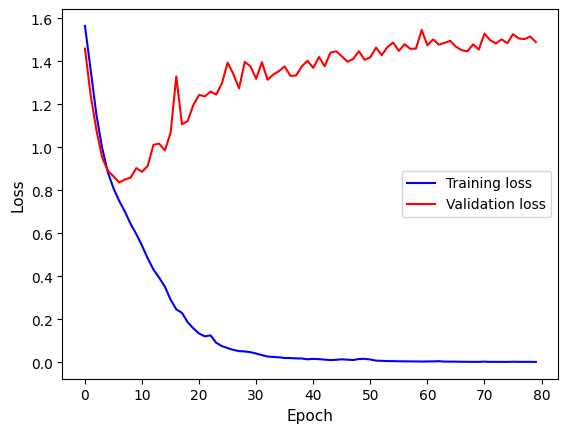

In [17]:
#plt.title('Loss Curve for Model')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

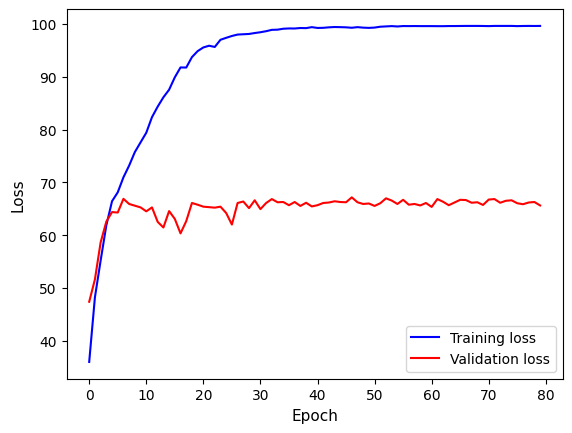

In [18]:
#plt.title('Accuracy Curve for Model')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.plot(train_accuracy[:],'b')
plt.plot(valid_accuracy[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [19]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

def make_validate_fnc(model,criterion):
    def validate(X,Y):
        with torch.no_grad():

            model.eval()

            # get predictions
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            
            # Convert predictions and true labels to numpy arrays
            predictions_np = predictions.cpu().numpy()
            y_true_np = Y.cpu().numpy()

            # Compute classification report
            report = classification_report(y_true_np, predictions_np)

            # Calculate precision, recall, and F1 score
            precision = precision_score(y_true_np, predictions_np, average='weighted') * 100
            recall = recall_score(y_true_np, predictions_np, average='weighted') * 100
            f1 = f1_score(y_true_np, predictions_np, average='weighted') * 100
            acc = accuracy_score(y_true_np, predictions_np) * 100
            acc_weighted = accuracy_score(y_true_np, predictions_np, sample_weight=None) * 100

        return predictions, precision, recall, f1, acc, acc_weighted, report
    return validate

In [20]:
optimizer = None

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename, map_location=torch.device('cpu'))
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [21]:
import os 

load_folder = '../../savedModel'
model_name = f'CNN1D_v3_best_acc.pkl'
load_path = os.path.join(load_folder, model_name)

model = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=len(emotions_dict))
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from ../../savedModel\CNN1D_v3_best_acc.pkl


In [22]:
model.to(device)

validate = make_validate_fnc(model,criterion)

# Convert to tensors
X_test_tensor = torch.tensor(X_test,device=device).float()
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)

predictions, precision, recall, f1, acc, acc_weighted, report = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy (UA) is {acc:.2f}')
print(f'Test accuracy (WA) is {acc_weighted:.2f}')
print(f'Test precision is {precision:.2f}')
print(f'Test recall is {recall:.2f}')
print(f'Test F1 is {f1:.2f}')

print('\n',report)

Test accuracy (UA) is 67.16
Test accuracy (WA) is 67.16
Test precision is 66.93
Test recall is 67.16
Test F1 is 66.99

               precision    recall  f1-score   support

           0       0.47      0.48      0.48       232
           1       0.64      0.70      0.67       455
           2       0.62      0.58      0.60       642
           3       0.99      0.99      0.99       248
           4       0.96      1.00      0.98       238
           5       0.50      0.47      0.48       338

    accuracy                           0.67      2153
   macro avg       0.70      0.70      0.70      2153
weighted avg       0.67      0.67      0.67      2153

